In [11]:
import numpy as np
import pandas as pd
import os,re,sys,random
from scipy import interp
import multiprocessing.pool
from allennlp.commands.elmo import ElmoEmbedder
import torch
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras import backend as K
K.clear_session()
from keras import layers, optimizers, models, regularizers
from keras.layers import *
from keras.models import *
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

class Elmo_embedder():
    def __init__(self, model_dir="/public/home/hxu6/projects/degron/DegronsDB/model/uniref50_v2", weights="weights.hdf5",
                 options="options.json", threads=1000):
        if threads == 1000:
            torch.set_num_threads(multiprocessing.cpu_count() // 2)
        else:
            torch.set_num_threads(threads)

        self.model_dir = Path(model_dir)
        self.weights = self.model_dir / weights
        self.options = self.model_dir / options
        self.seqvec = ElmoEmbedder(self.options, self.weights, cuda_device=-1)

    def elmo_embedding(self, x, start=None, stop=None):
        assert start is None and stop is None, "deprecated to use start stop, please trim seqs beforehand"

        if type(x[0]) == str:
            x = np.array([list(i.upper()) for i in x])
        embedding = self.seqvec.embed_sentences(x)
        X_parsed = []
        for i in embedding:
            X_parsed.append(i.mean(axis=0))
        return X_parsed

In [12]:
elmo_embedder = Elmo_embedder(threads=60)       

In [13]:
def build_model(nodes, dropout, seq_length, weight_decay_lstm=1e-6, weight_decay_dense=1e-3):
    
    embedding_input = Input(shape=(seq_length, 1024))
    
    left1 = Conv1D(128, 8, padding='valid',activation='relu',strides=1)(embedding_input)
    left1 = MaxPooling1D(pool_size=2, strides=None, padding='valid')(left1) 
    
    left2 = Bidirectional(LSTM(nodes, input_shape=(seq_length, 1024), return_sequences=True, dropout=dropout,
                    recurrent_dropout=0.2, kernel_regularizer=l2(weight_decay_lstm),
                    recurrent_regularizer=l2(weight_decay_lstm), bias_regularizer=l2(weight_decay_lstm)))(
        embedding_input)
                    
    left2 = Bidirectional(LSTM(nodes // 2, dropout=dropout, return_sequences=True, recurrent_dropout=0.5,
                    kernel_regularizer=l2(weight_decay_lstm), recurrent_regularizer=l2(weight_decay_lstm),
                    bias_regularizer=l2(weight_decay_lstm)))(left2)                
                    
    left1 = Dense(nodes)(left1)
    left1 = LeakyReLU(alpha=0.01)(left1)
    out_left1 = Flatten()(left1)
    
    left2 = Dense(nodes)(left2)
    left2 = LeakyReLU(alpha=0.01)(left2)
    out_left2 = Flatten()(left2)
    

    seq_input = Input(shape=(seq_length,))
    right = Embedding(27, 10, input_length=seq_length)(seq_input)
    right = Bidirectional(
        LSTM(nodes, return_sequences=True, dropout=dropout,
                    recurrent_dropout=0.2, kernel_regularizer=l2(weight_decay_lstm),
                    recurrent_regularizer=l2(weight_decay_lstm), bias_regularizer=l2(weight_decay_lstm)))(right)
    
    right = Dense(nodes)(right)
    right = LeakyReLU(alpha=0.01)(right)
    out_right = Flatten()(right)

    hidden = concatenate([out_left1, out_left2, out_right])

    hidden = Dense(nodes, kernel_regularizer=l2(weight_decay_dense), bias_regularizer=l2(weight_decay_dense))(
        hidden)

    hidden = LeakyReLU(alpha=0.01)(hidden)

    out = Dense(1, activation='sigmoid', kernel_regularizer=l2(weight_decay_dense),
                       bias_regularizer=l2(weight_decay_dense))(hidden)

    model = models.Model(inputs=[embedding_input, seq_input], outputs=out)

    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [14]:
def draw_cv_roc_and_pr_curve_DL(cv, X1, X2, y, fileroc):
    
    nodes = 20
    shift = 14
    dropout = 0.5
    seq_length = 29
    
    tprs = []
    aucs = []

    mean_fpr = np.linspace(0, 1, 100)
    
    y_real = []
    y_proba = []
    test_ind = []
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

    font1 = {'family' : 'Times New Roman',
            'weight' : 'normal',
            'size'   : 16}
    figsize=5, 5
    
    ########ROC_figure
    figure1, ax1 = plt.subplots(figsize=figsize)
    ax1.tick_params(labelsize=14)
    labels = ax1.get_xticklabels() + ax1.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]  

    i = 0
    for train, test in cv.split(X1, y):
        
        classifier = build_model(nodes, dropout=dropout, seq_length=seq_length)
        
        mc = ModelCheckpoint(fileroc + '/model_%s.h5' % str(i), monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True, save_best_only=True)
        weights = compute_class_weight('balanced',classes=np.arange(2),y=np.squeeze(y[train]))

        train_input = [X1[train], X2[train]]
        test_input = [X1[test], X2[test]]
            
        classifier.fit(train_input,
                y[train],
                batch_size=64,
                epochs = 100,
                shuffle=True,
                callbacks=[es, mc],
                validation_data=(test_input, y[test]),
                class_weight = {i:weights[i] for i in range(len(weights))},
                verbose=1)
                       
        classifier.load_weights(fileroc + '/model_%s.h5' % str(i))
        probas_ = classifier.predict(test_input)       
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax1.plot(fpr, tpr, lw=1.5, alpha=0.5,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
        y_real.append(y[test])
        y_proba.append(probas_)

        del classifier
        
        i += 1
    
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)  
    
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
                label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=3.5, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate (FPR)',fontsize=14)
    ax1.set_ylabel('True Positive Rate (TPR)',fontsize=14)
    ax1.legend(loc="lower right",fontsize=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    figure1.savefig(fileroc + '/' + 'CV5_roc.png', dpi=300, bbox_inches = 'tight')
    

In [15]:
X_train_local = np.load('/public/home/hxu6/projects/degron/DegronsDB/data_patterns/all_train_embedding.npy', allow_pickle = True)
all_train_embedding = []
all_train_number_vec = []
all_train_lable = []
for hit in X_train_local:
    all_train_embedding.append(hit[2])
    all_train_number_vec.append(hit[3])
    all_train_lable.append(hit[-1])

train_x = np.array(all_train_embedding)
train_x1 = np.array(all_train_number_vec)
y = np.array(all_train_lable)

indices = np.arange(train_x.shape[0]) # help for check the index after split

np.random.seed(202310)
permutation = np.random.permutation(train_x.shape[0])
train_x = train_x[permutation, :, :]
train_x1 = train_x1[permutation, :]
train_x1 = train_x1.astype(np.float32)

y1 = y[permutation]
y1 = y1.astype(np.int)

X_train1, X_test1, y_train1, y_test1, idx11, idx21 = train_test_split(train_x, y1, indices, test_size=0.1, random_state=202309, stratify=y)
X_train2, X_test2, y_train2, y_test2, idx12, idx22 = train_test_split(train_x1, y1, indices, test_size=0.1, random_state=202309, stratify=y)


/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=202310) 
fileroc = '/public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test'
if not os.path.isdir(fileroc):
    os.makedirs(fileroc) 

Train on 1245 samples, validate on 312 samples
Epoch 1/100
1245/1245 [==============================] - 4s 3ms/step - loss: 0.7342 - accuracy: 0.5301 - val_loss: 0.6474 - val_accuracy: 0.8173

Epoch 00001: val_accuracy improved from -inf to 0.81731, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_0.h5
Epoch 2/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.6734 - accuracy: 0.6972 - val_loss: 0.5482 - val_accuracy: 0.8462

Epoch 00002: val_accuracy improved from 0.81731 to 0.84615, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_0.h5
Epoch 3/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.5703 - accuracy: 0.7285 - val_loss: 0.5331 - val_accuracy: 0.7821

Epoch 00003: val_accuracy did not improve from 0.84615
Epoch 4/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.4972 - accuracy: 0.7663 - val_loss: 0.4047 - val_a

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 1245 samples, validate on 312 samples
Epoch 1/100
1245/1245 [==============================] - 4s 3ms/step - loss: 0.7200 - accuracy: 0.5133 - val_loss: 0.7033 - val_accuracy: 0.6218

Epoch 00001: val_accuracy improved from -inf to 0.62179, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_1.h5
Epoch 2/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.6646 - accuracy: 0.6450 - val_loss: 0.5450 - val_accuracy: 0.8269

Epoch 00002: val_accuracy improved from 0.62179 to 0.82692, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_1.h5
Epoch 3/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.5542 - accuracy: 0.7719 - val_loss: 0.4821 - val_accuracy: 0.8013

Epoch 00003: val_accuracy did not improve from 0.82692
Epoch 4/100
1245/1245 [==============================] - 1s 1ms/step - loss: 0.4218 - accuracy: 0.8273 - val_loss: 0.5011 - val_a

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 1246 samples, validate on 311 samples
Epoch 1/100
1246/1246 [==============================] - 4s 3ms/step - loss: 0.7208 - accuracy: 0.6268 - val_loss: 0.8326 - val_accuracy: 0.1833

Epoch 00001: val_accuracy improved from -inf to 0.18328, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_2.h5
Epoch 2/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.6319 - accuracy: 0.6717 - val_loss: 0.8688 - val_accuracy: 0.3730

Epoch 00002: val_accuracy improved from 0.18328 to 0.37299, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_2.h5
Epoch 3/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.5261 - accuracy: 0.7833 - val_loss: 0.6928 - val_accuracy: 0.5884

Epoch 00003: val_accuracy improved from 0.37299 to 0.58842, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_2.h5
Epoch 4/100
1246/

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 1246 samples, validate on 311 samples
Epoch 1/100
1246/1246 [==============================] - 5s 4ms/step - loss: 0.7164 - accuracy: 0.5682 - val_loss: 0.7618 - val_accuracy: 0.4309

Epoch 00001: val_accuracy improved from -inf to 0.43087, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_3.h5
Epoch 2/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.5989 - accuracy: 0.7368 - val_loss: 0.6027 - val_accuracy: 0.7299

Epoch 00002: val_accuracy improved from 0.43087 to 0.72990, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_3.h5
Epoch 3/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.4957 - accuracy: 0.7889 - val_loss: 0.5770 - val_accuracy: 0.7267

Epoch 00003: val_accuracy did not improve from 0.72990
Epoch 4/100
1246/1246 [==============================] - 2s 1ms/step - loss: 0.3729 - accuracy: 0.8435 - val_loss: 0.3931 - val_a

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 1246 samples, validate on 311 samples
Epoch 1/100
1246/1246 [==============================] - 5s 4ms/step - loss: 0.7324 - accuracy: 0.5811 - val_loss: 0.7894 - val_accuracy: 0.1768

Epoch 00001: val_accuracy improved from -inf to 0.17685, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_4.h5
Epoch 2/100
1246/1246 [==============================] - 2s 1ms/step - loss: 0.6719 - accuracy: 0.5827 - val_loss: 0.5484 - val_accuracy: 0.8489

Epoch 00002: val_accuracy improved from 0.17685 to 0.84887, saving model to /public/home/hxu6/projects/degron/DegronsDB/data_patterns/Deep_model_AUROC_test/model_4.h5
Epoch 3/100
1246/1246 [==============================] - 2s 1ms/step - loss: 0.5587 - accuracy: 0.7640 - val_loss: 0.6077 - val_accuracy: 0.6559

Epoch 00003: val_accuracy did not improve from 0.84887
Epoch 4/100
1246/1246 [==============================] - 1s 1ms/step - loss: 0.4342 - accuracy: 0.8098 - val_loss: 0.3892 - val_a

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


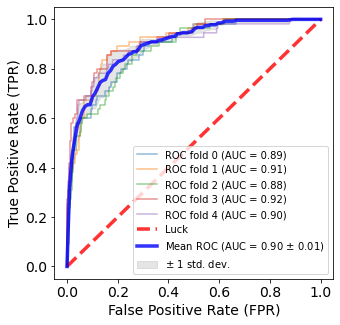

In [17]:
draw_cv_roc_and_pr_curve_DL(cv, X_train1, X_train2, y_train1, fileroc)